# Kernel Density Estimate and Nonparametric Regressions

This notebook uses non-parametric methods to estimate distributions and regressions.

# Load Packages and Extra Functions

The key functions used in this notebook are in the (local) `FinEcmt_KernelRegression` module. 

In [1]:
MyModulePath = joinpath(pwd(),"src")
!in(MyModulePath,LOAD_PATH) && push!(LOAD_PATH,MyModulePath)
using FinEcmt_OLS, FinEcmt_KernelRegression

[ Info: Precompiling FinEcmt_KernelRegression [top-level] (cache misses: incompatible header (2))


In [2]:
#=
include(joinpath(pwd(),"src","FinEcmt_OLS.jl"))
include(joinpath(pwd(),"src","FinEcmt_KernelRegression.jl"))
using .FinEcmt_OLS, .FinEcmt_KernelRegression
=#

In [3]:
using DelimitedFiles, Statistics

In [4]:
using Plots
default(size = (480,320),fmt = :png)

## Loading Data

The data consists of daily returns on U.S. large caps.

In [5]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
R   = xx[:,11]            #returns for the portfolio we want to study
xx  = nothing

y   = R[2:end]            #dependent variable
x   = R[1:end-1]          #regressor
T   = size(x,1)

println("Sample size: $T")

Sample size: 8324


# Kernel Density Estimate

The `KernelDensity()` function included above estimates the probability density function (pdf) by using a gaussian kernel. The bandwidth parameter (`h`) can be supplied by the caller, otherwise it defaults to the rule of thumb value $h=1.06\textrm{std}(x)/T^{0.2}$. In practice, the choice of kernel is less important that the choice of bandwidth.

The estimate of the pdf at value $x$ is
$\hat{f}\left(  x\right)  =\frac{1}{h}\frac{1}{T}\sum_{t=1}^{T}K(\frac{x_{t}-x}{h}),$

where $K()$ is one of the kernel functions listed below.

The function outputs both the estimate the estimate of $\textrm{pdf}(x)$, denoted `fx`, and its standard deviation, denoted `Stdfx`.

As an alternative to this code, consider the [KernelDensity.jl](https://github.com/JuliaStats/KernelDensity.jl) package.

In [6]:
@doc2 KernelDensity

```
KernelDensity(x,xGrid,h=[],KernelFun=GaussianKernel)
```

Compute a kernel density estimate at each value of the grid `xGrid`, using the data in vector `x`. The bandwidth `h` can be specified (otherwise a default value is used). The kernel function defaults to a standard normal density function, but other choices are available.


In [7]:
#using CodeTracking
#println(@code_string KernelDensity([1],[1]))

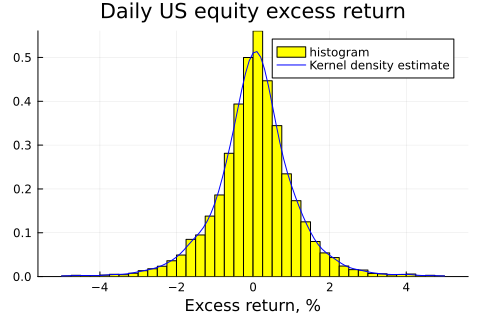

In [8]:
xGrid = -5:0.1:5
pdfX, = KernelDensity(x,xGrid)

p1 = histogram( x,bins = -5:0.25:5,
                normalized = true,
                fillcolor = :yellow,
                label = "histogram",
                title = "Daily US equity excess return",
                xlabel = "Excess return, %" )
plot!(xGrid,pdfX,linewidth=1,color=:blue,label="Kernel density estimate")
display(p1)

# Kernel Regression

is a regression of the sort 
$y_t = b(x_{t}) + \epsilon_t$
where regression function $b()$ is effectively assumed to be constant in a neighbourhood of a grid point $x$. Many grid points are considered, so the function is approximated by a step function: fixed value around each grid point $x$.

The fitted value of $b(x)$ (that is, evaluated a particular $x$-value) in a kernel regression is calculated as

$\hat{b}(x)=\frac{\sum_{t=1}^{T}w(x_t-x)y_{t}}{\sum_{t=1}^{T}w(x_t-x)},$

where $w(x_t-x)$ is the weight of observation $t$, defined by a kernel function. This can be implemented as a regression 
of $\sqrt{w_t}y_t$ on $\sqrt{w_t}1$, which also gives a valid standard error of the estimates. (The function below uses White's method.)

The function `KernelRegression()` uses one of the kernels listed above to do the estimation. It defaults to the Gaussian kernel.

It estimates $b(x)$ at each point $x$ in the vector `xGrid`. The function requires the user to input a bandwidth parameter `h`.

As an alternative to this code, consider the [NonparametricRegression.jl](https://github.com/tbeason/NonparametricRegression.jl) package.

In the application below, we are estimating a non-parametric AR(1) for returns.

In [9]:
@doc2 KernelRegression

```
KernelRegression(y,x,xGrid,h,vv = :all,DoCovb=true,KernelFun=GaussianKernel)
```

Do kernel regression `y[vv] = b(x[vv])`, evaluated at each point in the `xGrid` vector, using bandwidth `h`. Implemented as weighted least squares (WLS), which also provide heteroskedasticity robust standard errors.

### Input

  * `y::Vector`:      T-vector with data for the dependent variable
  * `x::Vector`:      T-vector with data for the regressor
  * `xGrid::Vector`:  Ngrid-vector with grid points where the estimates are done
  * `vv::Symbol or Vector`: If `vv = :all`, then all data points are used, otherwise supply indices.
  * `DoCovb::Bool`:    If true, the standard error of the estimate is also calculated
  * `KernelFun::Function`: Function used as kernel.

### Remark

  * The `vv` and `DoCovb=false` options are useful for speeding up the cross-validation below.


In [10]:
#println(@code_string KernelRegression([1],[1],[1],1))

In [11]:
xGrid = -10:0.25:10                          #x values to estimate b(x) at
h     = 1.5

(bHat,StdbHat) = KernelRegression(y,x,xGrid,h)             #baseline choice of h
bHatHih,       = KernelRegression(y,x,xGrid,h*2)           #high h
bHatLoh,       = KernelRegression(y,x,xGrid,h*0.5);        #low h

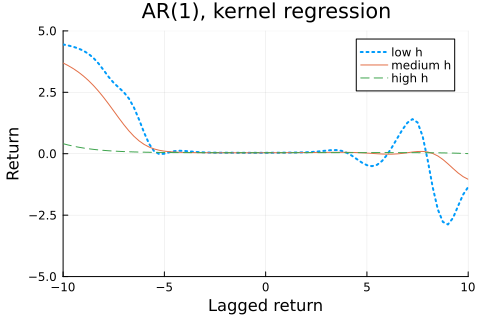

In [12]:
p1 = plot( xGrid,[bHatLoh bHat bHatHih],
           linestyle = [:dot :solid :dash],
           linewidth = [2 1 1],
           label = ["low h" "medium h" "high h"],
           xlim = extrema(xGrid),
           ylim = (-5,5),
           title = "AR(1), kernel regression",
           xlabel = "Lagged return",
           ylabel = "Return" )
display(p1)

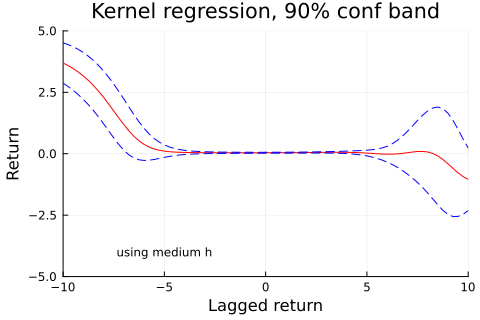

In [13]:
p1 = plot( xGrid,[bHat (bHat-1.645*StdbHat) bHat+1.645*StdbHat],
           linecolor = [:red :blue :blue],
           linestyle = [:solid :dash :dash],
           label = "",
           title = "Kernel regression, 90% conf band",
           xlabel = "Lagged return",
           ylabel = "Return",
           xlim = extrema(xGrid),
           ylim = (-5,5),
           annotation = (-5,-4,text("using medium h",8)))
display(p1)

## Rule of Thumb Choice of h

for the non-parametric regression.

Run the regression 

$y=\alpha+\beta x+\gamma x^{2}+\varepsilon$

and use the following rule-of-thumb choice

$h  =T^{-1/5}|\gamma|^{-2/5}\sigma_{\varepsilon}^{2/5}(x_{\max}-x_{\min})^{1/5}\times0.6.$

In practice, replace $x_{\max}-x_{\min}$ by the difference between the 90th
and 10th percentiles of $x$.

This is implemented in the `hRuleOfThumb()` function (included above).

In [14]:
h_crude = hRuleOfThumb(y,x)
printlnPs("\nRule-of-thumb value of h: ",h_crude)


     0.667umb value of h: 


## Cross-Validation (extra)

to choose the bandwidth $h$ for the kernel regression.

To do a cross-validation (leave-one-out)

(1) Pick a bandwidth $h$, do the kernel regression
but leave out observation $t$ and then record the out-of-sample prediction error $y_{t}-\hat{b}_{-t}
(x_{t},h)$. Notice that this is the error for observation $t$ only. 

(2) Repeat for all $t=1-T$ to calculate the EPE

$\text{EPE}(h)=\sum_{t=1}^{T}[  y_{t}-\hat{b}_{-t}(x_{t},h)]  ^{2}/T,$

(3) Finally, redo for several different values of $h$, and pick the $h$ value
that minimizes $\text{EPE}(h)$. 

### A Remark on the Code

Notice: Cross-validation calculations *take some time*. To save some computations the standard errors (which are not needed)
are not calculated.

In [15]:
hM = h_crude*[0.5,0.75,1,1.5,2,3,4,5,10]   #candiate h values

Nh   = length(hM)
EPEM = fill(NaN,(T,Nh))
for t = 1:T
    local v_No_t, b_t
    v_No_t = setdiff(1:T,t)     #exclude t from estimation
    for j = 1:Nh                #loop over hM[j] values
        b_t,      = KernelRegression(y,x,x[t],hM[j],v_No_t,false)  #calculate fitted b(x[t])
        EPEM[t,j] = (y[t] - b_t[1])^2     #out-of-sample error
    end
end

EPE = mean(EPEM,dims=1)'

printblue("Cross-validation of bandwidth (h):\n")
printmat(hM,EPE,colNames=["h","EPE"])

Cross-validation of bandwidth (h):

         h       EPE
     0.334     1.314
     0.501     1.302
     0.667     1.295
     1.001     1.288
     1.335     1.286
     2.002     1.287
     2.670     1.291
     3.337     1.292
     6.674     1.296



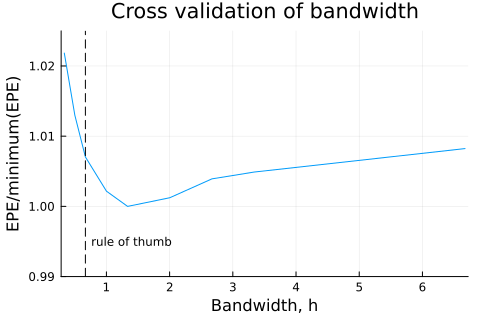

In [16]:
p1 = plot( hM,EPE/minimum(EPE),
           legend = false,
           xlim = (minimum(hM)-0.05,maximum(hM)+0.05),
           ylim = (0.99,1.025),
           title = "Cross validation of bandwidth",
           xlabel = "Bandwidth, h",
           ylabel = "EPE/minimum(EPE)",
           annotation = (1.4,0.995,text("rule of thumb",8)) )
vline!([h_crude],linecolor=:black,line=(:dash,1))
display(p1)

# Local Linear Regression

estimates 

$y_t = a + b (x_t-x) + \epsilon_t$

for a grid of $x$ values. This can also be implemented as weighted least squares (which gives both point estimates and valid standard errors). This is implemented in the `LocalLinearRegression()` function.

In [17]:
@doc2 LocalLinearRegression

```
LocalLinearRegression(y,x,xGrid,h,vv = :all,DoCovb=true,KernelFun=GaussianKernel)
```

Do local linear regression `y = a + b(x-xGrid[i])`, where both `a` and `b` will differ across `xGrid[i]` values. The estimates of `a` and their standard errors are exported.

See `KernRegrFn()` for further comments


In [18]:
#println(@code_string LocalLinearRegression([1],[1],[1],1))

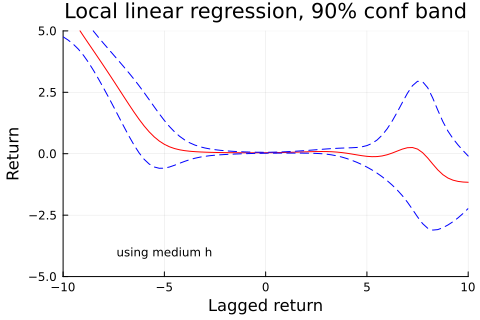

In [19]:
xGrid = -10:0.25:10                          #x values to estimate b(x) at
h     = 1.5
(aHat,StdaHat) = LocalLinearRegression(y,x,xGrid,h);             #baseline choice of h

p1 = plot( xGrid,[aHat (aHat-1.645*StdaHat) aHat+1.645*StdaHat],
           linecolor = [:red :blue :blue],
           linestyle = [:solid :dash :dash],
           label = "",
           title = "Local linear regression, 90% conf band",
           xlabel = "Lagged return",
           ylabel = "Return",
           xlim = extrema(xGrid),
           ylim = (-5,5),
           annotation = (-5,-4,text("using medium h",8)))
display(p1)